In [1]:
import os
import sys
import pylab as p
import pylab as pl
import matplotlib as mpl
import pylab as pl
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
sns.reset_defaults()
import warnings
warnings.filterwarnings('ignore')

# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['pdf.fonttype'] = 42


In [2]:
# Dependency Function Definitions:
def calc_rmsd(x, y):
    if len(x) == 0:
        return 0.0
    chi2 = sum((y - x) ** 2)
    rmsd = np.sqrt(chi2 / len(y))
    return rmsd

def calc_r2(x, y):
    if len(x) == 0:
        return 0.0
    correlation = np.corrcoef(y, x)[0,1]**2
    return correlation

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    common = []
    for element in list1:
        if element in list2:
            common.append(element)
    return list(c - d), common

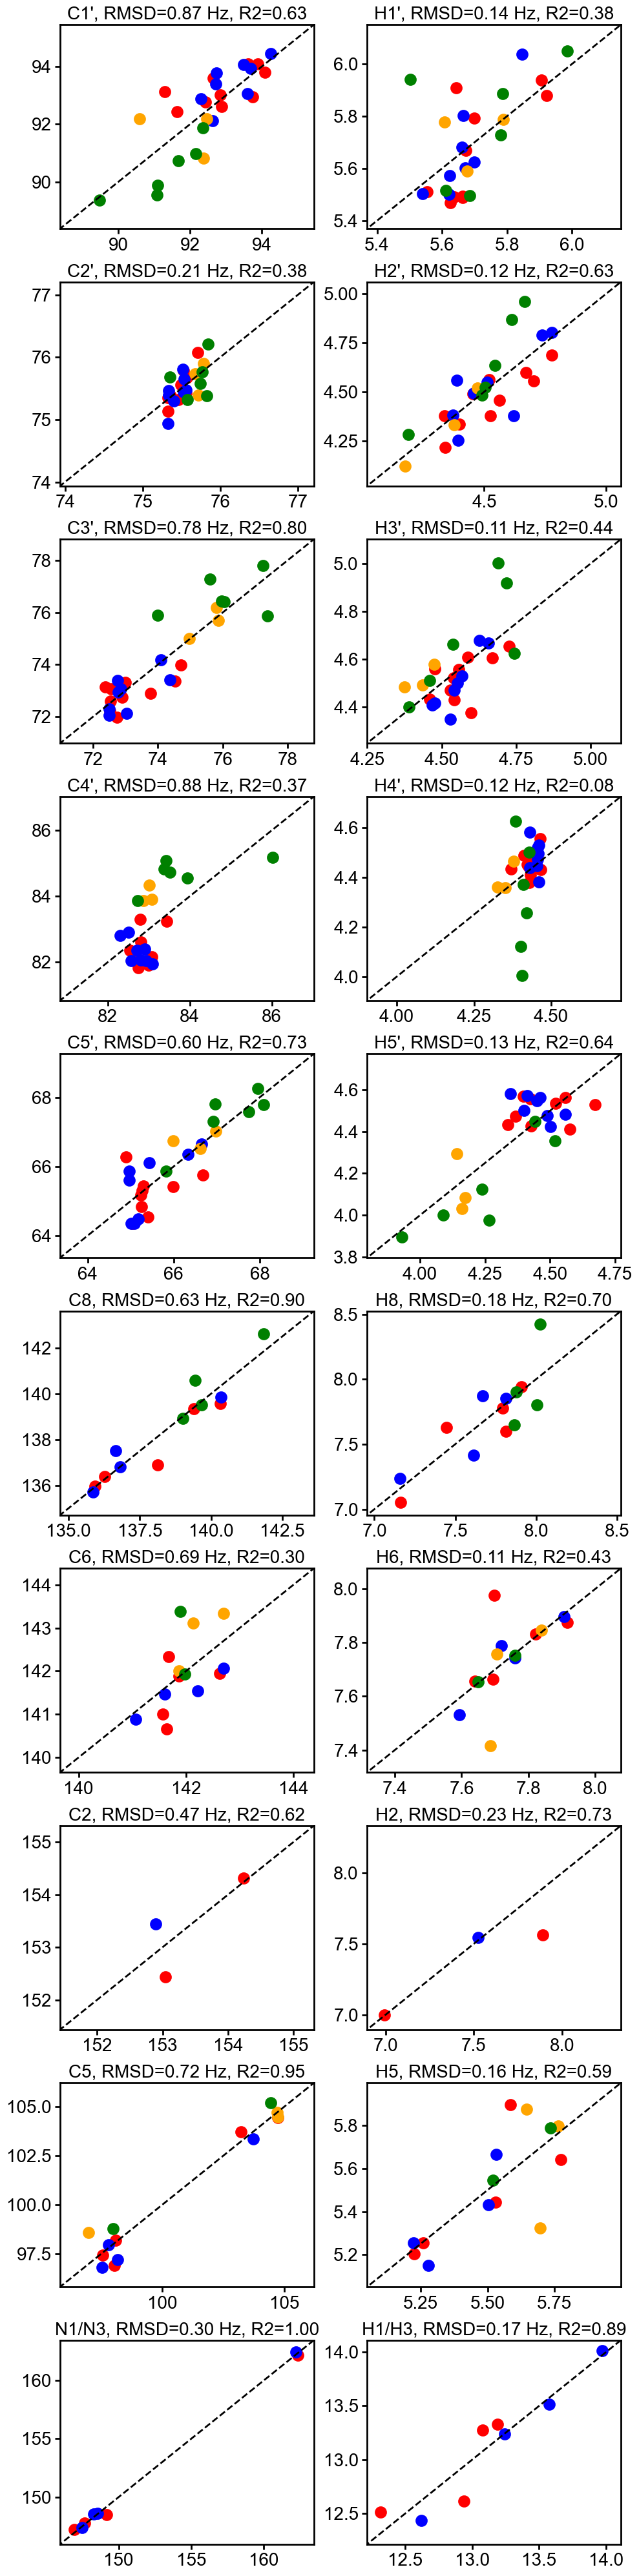

In [3]:
# FARFAR-Unbiased wt-TAR RDC Optimized Ensemble (N=20) [Lowest RMSD]
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.savefig("plots/FARFAR_NMR_LowestRMSD_Ensemble_DFT.pdf")
plt.show()

In [4]:
# FARFAR-NMR random N=20 conformer ensemble
# Read in CSV data
dfp = pd.read_csv("data/FARFAR-wt-TAR-PoolRandom_predictedCS.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.savefig("plots/FARFAR_Random_Ensemble_DFT.pdf")


C1' : y = 1.04 x + -8.88
C2' : y = 0.25 x + 55.77
C3' : y = 1.09 x + -7.09
C4' : y = 0.53 x + 39.99
C5' : y = 0.58 x + 26.62
C8 : y = 0.95 x + 13.41
C6 : y = 0.74 x + 39.99
C2 : y = 0.49 x + 79.28
C5 : y = 0.59 x + 42.19
N1/N3 : y = 0.61 x + 52.95


In [5]:
 # FARFAR-Unbiased wt-TAR Ensemble FARFAR-Energy Optimized (N=20) [Lowest Energy conformers by FARFAR]
# Read all ORca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestEnergy_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")


# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.nanmean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.nanstd(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.savefig("plots/FARFAR_LowestEnergy_Ensemble_DFT.pdf")


C1' : y = 0.92 x + 1.34
C2' : y = 0.19 x + 60.56
C3' : y = 0.41 x + 42.62
C4' : y = -0.25 x + 103.91
C5' : y = 0.50 x + 31.88
C8 : y = 0.91 x + 17.50
C6 : y = 0.12 x + 124.95
C2 : y = 0.35 x + 99.59
C5 : y = 0.62 x + 38.24
N1/N3 : y = 0.60 x + 53.51


In [6]:
# FARFAR-NMR wt-TAR RDC Optimized Ensemble (N=20) with inter and intra residue clash filter
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_Unbiased_NoClash_LowestRMSD_Ensemble.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L': 'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.savefig("plots/wtTAR_Unbiased_NoClash_LowestRMSD_Ensemble.pdf")


In [7]:
# FARFAR-Unbiased wt-TAR RDC Optimized Ensemble (for each conformer:) [Lowest RMSD]
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

RMSD_ = []
CONF_ = []
RESONANCE_ = []
R2_ = []

for i in range(1, 21):
    print("CONFORMER ", i+1)
    # Read in CSV data
    dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
    dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

    # Process & combine predicted & measured data
    dfp['shift_ens_avg'] = dfp['shift_%i'%i]
    dfp['shift_ens_std'] = dfp['shift_%i'%i] * 0 # set to 0 
    dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
    dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
        'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
    df = dfm.merge(dfp, on=["res", "atom"], how="inner")

    # Define masks for TAR domains:
    mask = {}
    mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
    mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
    mask['B'] = df.res.isin([23, 24, 25])
    mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

    # Define resonances & TAR domains to plot:
    domains = ['H1', 'H2', 'B', 'L']
    domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
    resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
    N = len(resonances)

    # Prepare figure layout
    fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

    # Loop through diff. nuclei:
    for idx, resonance in enumerate(resonances):
        if resonance == "N1/N3":
            G_iminos = [18, 21, 26, 28, 36, 43]
            U_iminos = [38, 42]
            filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
            filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
            filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
            filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
            filter1 = filter_N1 | filter_N3
            filter2 = filter_H1 | filter_H3
            resonance_H = "H1/H3"
            #print(df.loc[filter1])
        else:
            filter1 = (df["atom"] == resonance)
            resonance_H = "H" + resonance[1:]
            filter2 = (df["atom"] == resonance_H)
    
        # Calculate linear correction:
        x = df.loc[filter1]["shift_ens_avg"]
        y = df.loc[filter1]["shift_nmr_avg"]
        m, b = np.polyfit(x, y, 1)   
        #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
        x_H = df.loc[filter2]["shift_ens_avg"]
        y_H = df.loc[filter2]["shift_nmr_avg"]
        m_H, b_H = np.polyfit(x_H, y_H, 1)   
        #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
        # Set up limits of axes
        lim_up = max(np.max(y), np.max(x*m+b)) + 1
        lim_down = min(np.min(y), np.min(x*m+b)) - 1
        axs[idx, 0].set_xlim([lim_down, lim_up])
        axs[idx, 0].set_ylim([lim_down, lim_up])
        lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
        lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
        axs[idx, 1].set_xlim([lim_down, lim_up])
        axs[idx, 1].set_ylim([lim_down, lim_up])
    
        for domain in domains:
            # Plot heavy atom:
            df_f = df.loc[(mask[domain]) & (filter1)]
            if df_f.shape[0] == 0:
                continue
            else:
                col = domain_cols[domain]
                axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
            # Plot proton associated with it:
            df_f = df.loc[(mask[domain]) & (filter2)]
            if df_f.shape[0] == 0:
                continue
            else:
                col = domain_cols[domain]
                axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
        axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
        axs[idx, 0].tick_params(width=2,length=6)
        axs[idx, 1].tick_params(width=2,length=6)
    
        x=np.array(x)
        y=np.array(y)
        x_H = np.array(x_H)
        y_H = np.array(y_H)
 
        R2 = calc_r2(m*x+b, y)
        RMSD = calc_rmsd(m*x+b, y)
        axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
        R2_H = calc_r2(m_H*x_H+b_H, y_H)
        RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
        axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
        axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
        axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)
        
        CONF_.append(i)
        RMSD_.append(RMSD)
        R2_.append(R2)
        RESONANCE_.append(resonance)
        
        CONF_.append(i)
        RMSD_.append(RMSD_H)
        R2_.append(R2_H)
        RESONANCE_.append(resonance_H)
        
        fig.tight_layout()
        plt.savefig("plots/CS_per_conf/FARFAR_NMR_conf_%d.pdf"%i)

df = pd.DataFrame()
df["conf"] = CONF_
df["resonance"] = RESONANCE_
df["rmsd"] = RMSD_
df["r2"] = R2_

print(df.head())

CONFORMER  2
CONFORMER  3
CONFORMER  4
CONFORMER  5
CONFORMER  6
CONFORMER  7
CONFORMER  8
CONFORMER  9
CONFORMER  10
CONFORMER  11
CONFORMER  12
CONFORMER  13
CONFORMER  14
CONFORMER  15
CONFORMER  16
CONFORMER  17
CONFORMER  18
CONFORMER  19
CONFORMER  20
CONFORMER  21
   conf resonance      rmsd        r2
0     1       C1'  1.360725  0.082416
1     1       H1'  0.168387  0.163506
2     1       C2'  0.243652  0.202270
3     1       H2'  0.172268  0.237967
4     1       C3'  1.389790  0.348463


In [6]:
df_heavy = df.loc[df.resonance.isin(["C1'", "C2'", "C3'", "C4'", "C5'", "C6", "C8", "C2", "C5"])]
df_H = df.loc[df.resonance.isin(["H1'", "H2'", "H3'", "H4'", "H5'", "H6", "H8", "H2", "H5"])]
print("Heavy atom:")
print(np.mean(df_heavy.rmsd))
print(np.mean(df_heavy.r2))

print("Protons:")
print(np.mean(df_H.rmsd))
print(np.mean(df_H.r2))

Heavy atom:
0.9369774565749658
0.3705405939298116
Protons:
0.17175855972613924
0.3023545285822592


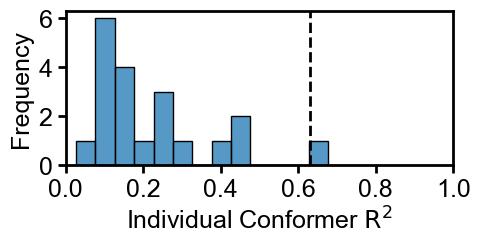

In [9]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 5,2


df_sub = df.loc[df["resonance"] == "C1'"]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.63, lw=2, ls="--", color="black", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)
plt.show()
plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C1p.pdf")

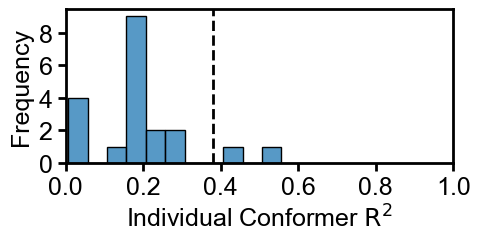

In [10]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 5,2


df_sub = df.loc[df["resonance"] == "C2'"]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.38, lw=2, ls="--", color="black", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)
plt.show()
plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C2p.pdf")

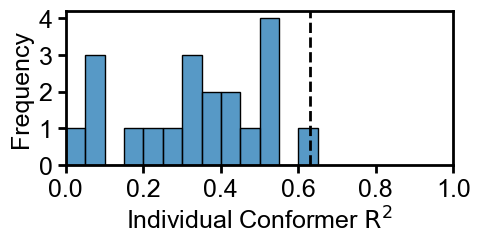

In [11]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 5,2


df_sub = df.loc[df["resonance"] == "C3'"]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.63, lw=2, ls="--", color="black", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)
plt.show()
plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C3p.pdf")

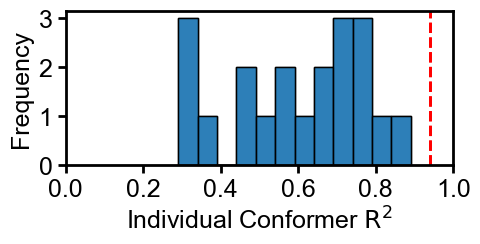

In [23]:
df_sub = df.loc[(df["resonance"] == "C8")]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.94, lw=2, ls="--", color="red", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)
plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C8.pdf")
plt.show()

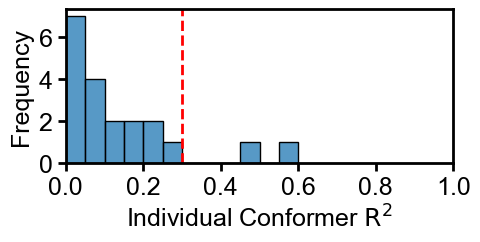

In [24]:
df_sub = df.loc[(df["resonance"] == "C6")]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.3, lw=2, ls="--", color="red", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)
plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C6.pdf")
plt.show()

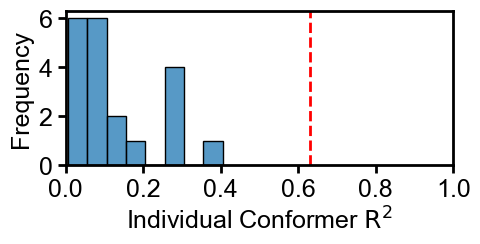

In [25]:
df_sub = df.loc[df["resonance"] == "C4'"]
sns.histplot(data=df_sub["r2"], binwidth=0.05)
plt.axvline(0.63, lw=2, ls="--", color="red", label="ensemble")
#sns.histplot(data=df_aromatic["r2"], color="blue", binwidth=0.05, label="C8/C6/C2")
plt.xlabel(r"Individual Conformer ${\rm R^2}$", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.legend(fontsize=16)
plt.xlim([0, 1])
plt.gca().tick_params(width=2,length=6)

plt.savefig("plots/CS_per_conf/FARFAR_NMR_Compare_C4p.pdf")
plt.show()

In [15]:
print(df)

     conf resonance      rmsd        r2
0       1       C1'  1.360725  0.082416
1       1       H1'  0.168387  0.163506
2       1       C2'  0.243652  0.202270
3       1       H2'  0.172268  0.237967
4       1       C3'  1.389790  0.348463
..    ...       ...       ...       ...
395    20        H2  0.323187  0.453329
396    20        C5  0.846801  0.935081
397    20        H5  0.179446  0.488495
398    20     N1/N3  0.339379  0.997016
399    20     H1/H3  0.215781  0.824696

[400 rows x 4 columns]


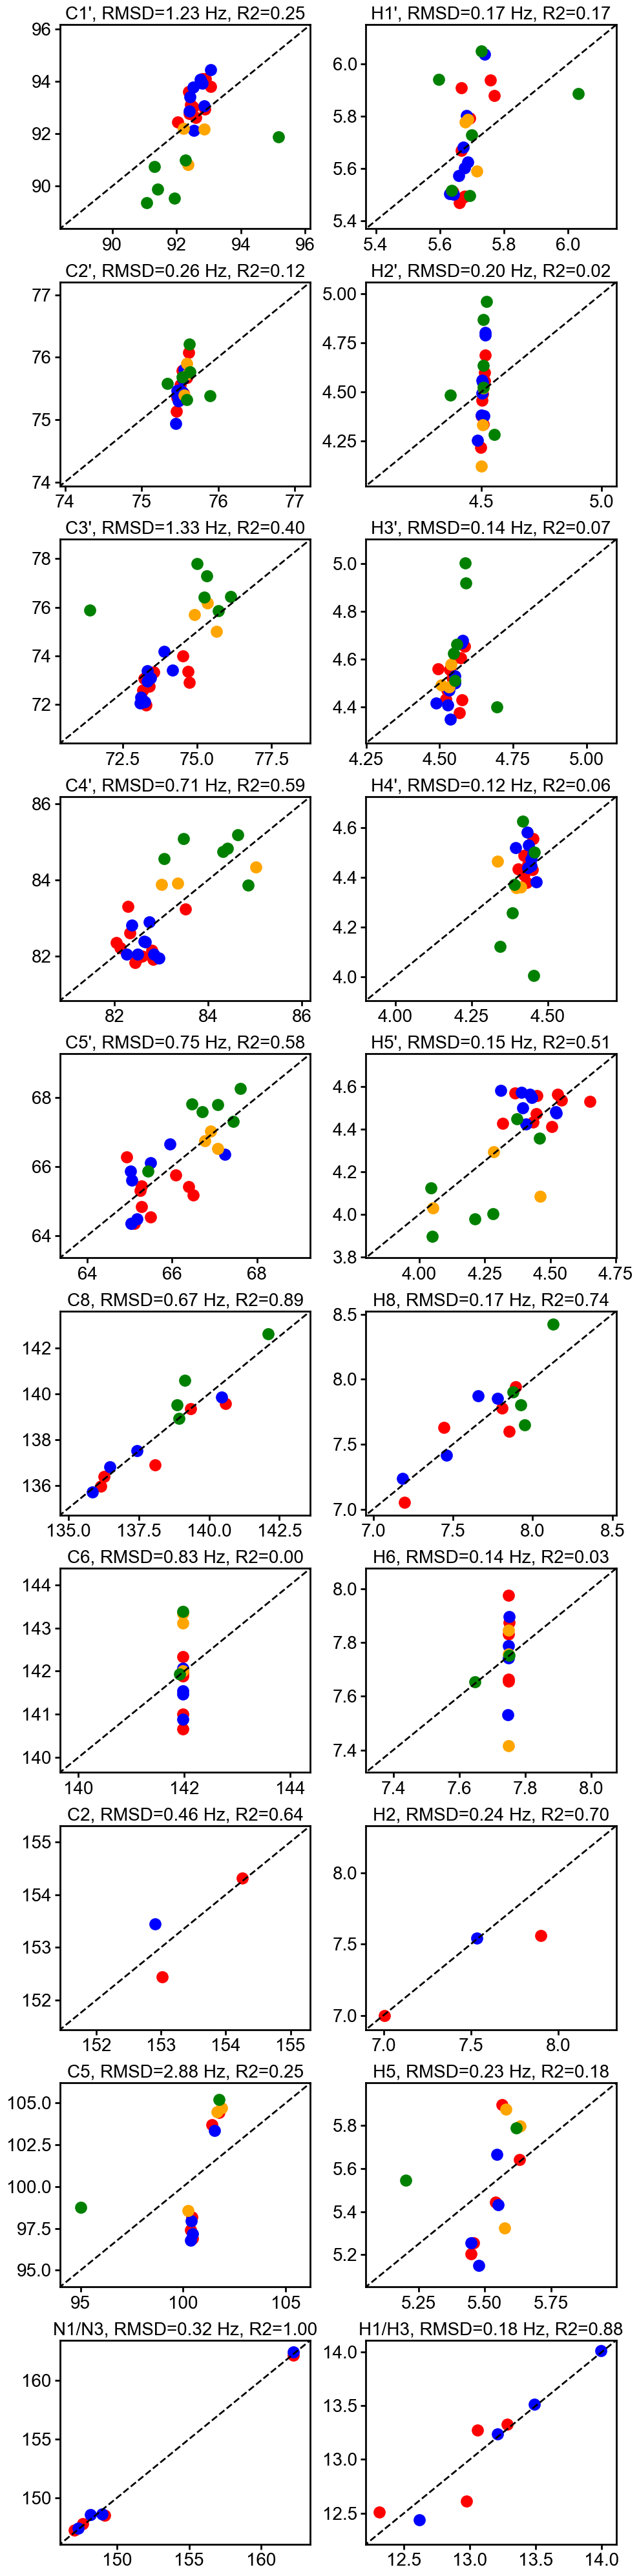

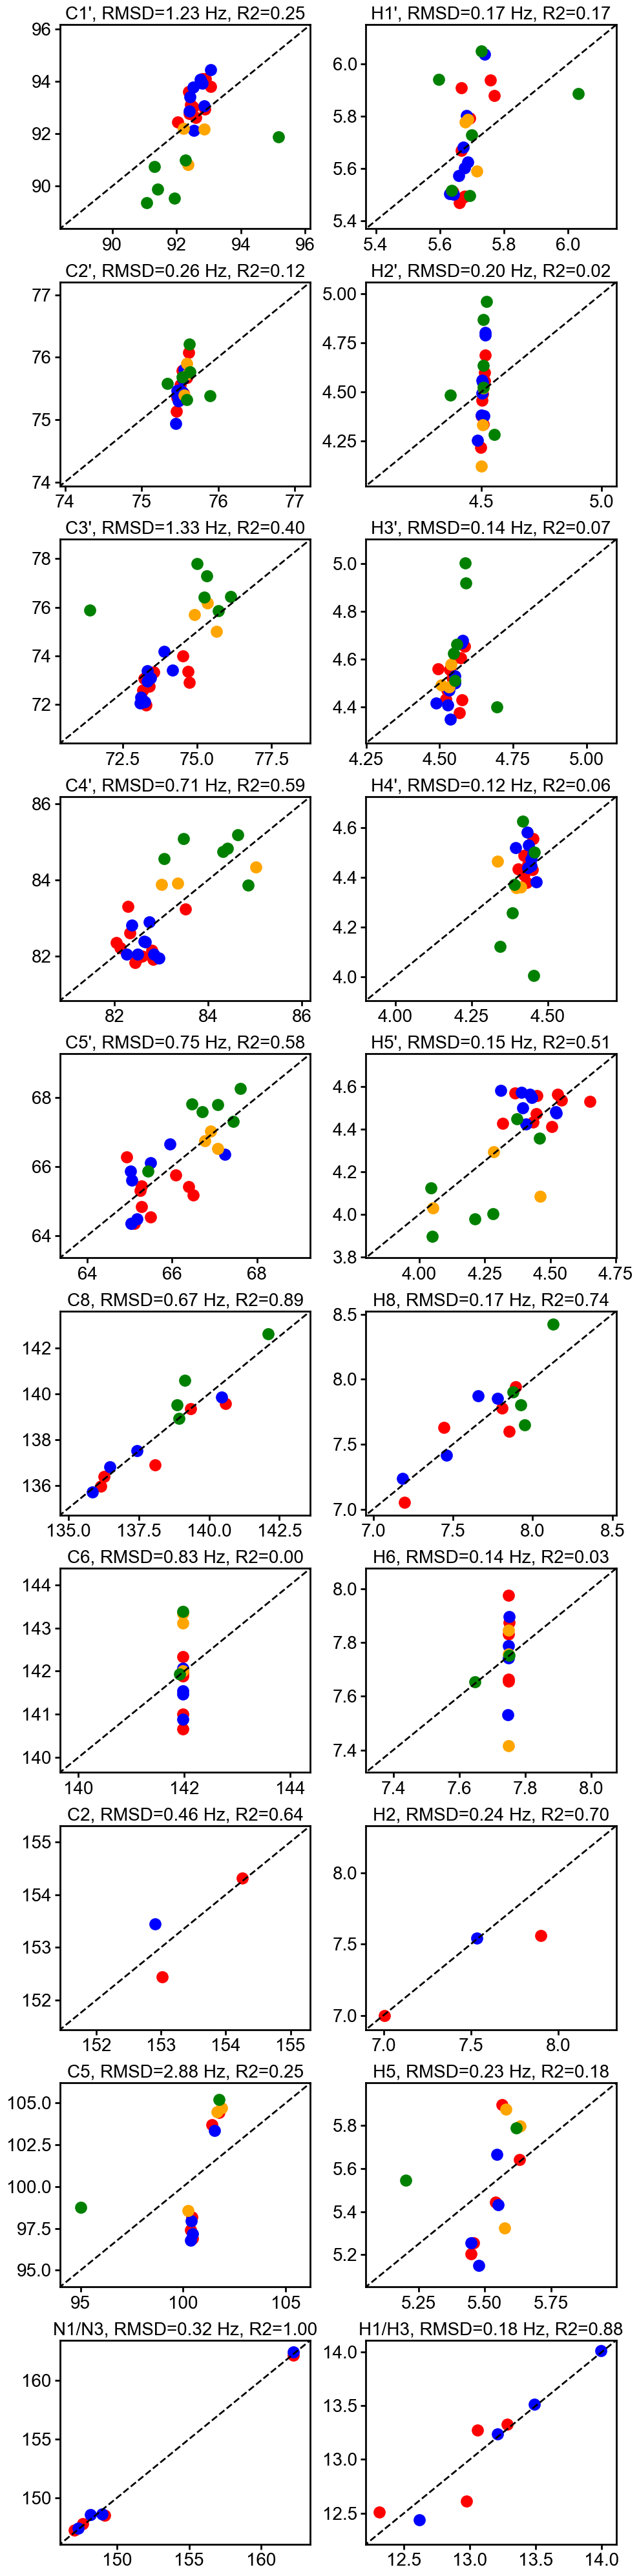

In [4]:
# FARFAR-NMR wt-TAR RDC Optimized Ensemble (N=20) with inter and intra residue clash filter
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_Unbiased_LowestRMSD_Ensemble_Replicate.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L': 'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.show()
plt.savefig("plots/wtTAR_Unbiased_LowestRMSD_Ensemble_Replicate.pdf")


C1' Purine  13C/15N : y = 1.16 x + -23.48
C1' Purine  1H : y = 0.58 x + 2.12
C1' Pyrimidine  13C/15N : y = 0.80 x + 13.28
C1' Pyrimidine  1H : y = 0.90 x + 0.02
C2' Purine  13C/15N : y = 0.31 x + 50.88
C2' Purine  1H : y = 0.85 x + 0.48
C2' Pyrimidine  13C/15N : y = 0.11 x + 66.98
C2' Pyrimidine  1H : y = 0.65 x + 1.32
C3' Purine  13C/15N : y = 0.73 x + 17.73
C3' Purine  1H : y = 1.07 x + -0.54
C3' Pyrimidine  13C/15N : y = 0.94 x + 0.78
C3' Pyrimidine  1H : y = 0.29 x + 3.14
C4' Purine  13C/15N : y = 0.68 x + 26.47
C4' Purine  1H : y = -0.78 x + 8.10
C4' Pyrimidine  13C/15N : y = 1.35 x + -29.78
C4' Pyrimidine  1H : y = -0.21 x + 5.41
C5' Purine  13C/15N : y = 0.52 x + 29.81
C5' Purine  1H : y = 1.72 x + -3.38
C5' Pyrimidine  13C/15N : y = 0.94 x + -0.23
C5' Pyrimidine  1H : y = 2.55 x + -6.98
C8 Purine  13C/15N : y = 1.05 x + -2.00
C8 Purine  1H : y = 0.78 x + 1.86
C6 Pyrimidine  13C/15N : y = 0.64 x + 52.48
C6 Pyrimidine  1H : y = 0.34 x + 4.97
C2 Purine  13C/15N : y = 0.60 x + 61.6

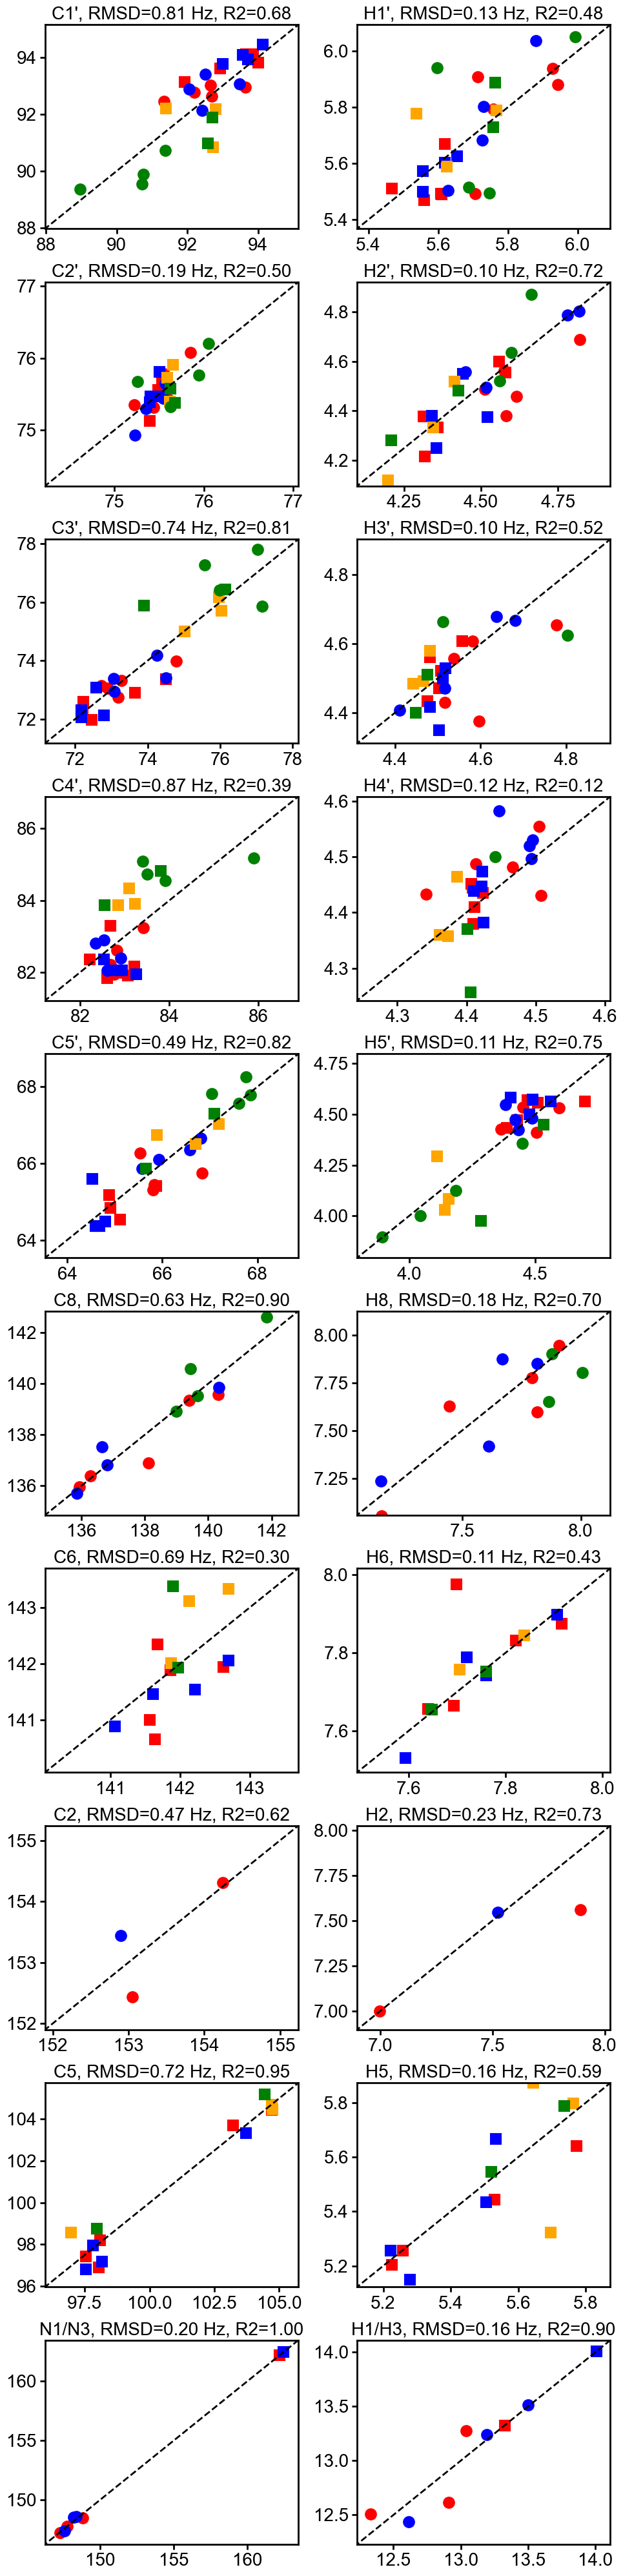

In [41]:
# FARFAR-Unbiased wt-TAR RDC Optimized Ensemble (N=20) [Lowest RMSD]
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

tar_seq = "GGCAGAUCUGAGCCUGGGAGCUCUCUGCC"
res_name = []
res_type = []
for idx, row in df.iterrows():
    resi = row['res']
    res_name_ = tar_seq[resi-17]
    if res_name_ == "A" or res_name_ == "G":
        res_type_ = "PUR"
    else:
        res_type_ = "PYR"
    res_name.append(res_name_)
    res_type.append(res_type_)

df["res_name"] = res_name
df["res_type"] = res_type

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    purine_filter = (df["res_type"] == "PUR")
    pyrimidine_filter = (df["res_type"] == "PYR")

    values = []
    mvalues = []
    values_H = []
    mvalues_H = []
    
    if df.loc[filter1 & purine_filter].shape[0] > 0:
        # Purines exist:
        x = df.loc[filter1 & purine_filter]["shift_ens_avg"]
        y = df.loc[filter1 & purine_filter]["shift_nmr_avg"]
        m_pur, b_pur = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & purine_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & purine_filter]["shift_nmr_avg"]
        m_H_pur, b_H_pur = np.polyfit(x_H, y_H, 1)
        print(resonance , "Purine  13C/15N : y = %3.2f x + %3.2f"%(m_pur, b_pur))
        print(resonance , "Purine  1H : y = %3.2f x + %3.2f"%(m_H_pur, b_H_pur))
        values += (x*m_pur + b_pur).tolist()
        values_H += (x_H*m_H_pur + b_H_pur).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
        
    if df.loc[filter1 & pyrimidine_filter].shape[0] > 0:
        # Pyrimidines exist:
        x = df.loc[filter1 & pyrimidine_filter]["shift_ens_avg"]
        y = df.loc[filter1 & pyrimidine_filter]["shift_nmr_avg"]
        m_pyr, b_pyr = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & pyrimidine_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & pyrimidine_filter]["shift_nmr_avg"]
        m_H_pyr, b_H_pyr = np.polyfit(x_H, y_H, 1)
        print(resonance , "Pyrimidine  13C/15N : y = %3.2f x + %3.2f"%(m_pyr, b_pyr))
        print(resonance , "Pyrimidine  1H : y = %3.2f x + %3.2f"%(m_H_pyr, b_H_pyr))
        values += (x*m_pyr + b_pyr).tolist()
        values_H += (x_H*m_H_pyr + b_H_pyr).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
    
    
    
    # Set up limits of axes
    lim_up = max(values) + 1
    lim_down = min(values) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(values_H) + 0.1
    lim_down = min(values_H) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom Purine:
        df_f = df.loc[(mask[domain]) & (filter1 & purine_filter)]
        #print(df_f)
        
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_pur * df_f.shift_ens_avg + b_pur, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
            #plt.plot( m_pur * df_f.shift_ens_avg + b_pur, df_f.shift_nmr_avg, 'o', color=col, 
            #                 markersize=12, mec=col, markeredgewidth=1.5)
        
        # Plot proton associated with it Purine:
        df_f = df.loc[(mask[domain]) & (filter2 & purine_filter)]
        
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_pur * df_f.shift_ens_avg + b_H_pur, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
            #plt.plot( m_H_pur * df_f.shift_ens_avg + b_H_pur, df_f.shift_nmr_avg, 'o', color=col, 
            #                 markersize=12, mec=col, markeredgewidth=1.5)
        
            
        df_f = df.loc[(mask[domain]) & (filter1 & pyrimidine_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_pyr * df_f.shift_ens_avg + b_pyr, df_f.shift_nmr_avg, 's', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it Purine:
        df_f = df.loc[(mask[domain]) & (filter2 & pyrimidine_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_pyr * df_f.shift_ens_avg + b_H_pyr, df_f.shift_nmr_avg, 's', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    #x=np.array(x)
    #y=np.array(y)
    #x_H = np.array(x_H)
    #y_H = np.array(y_H)
    #np.array(mvalues)
    R2 = calc_r2(np.array(values), np.array(mvalues))
    RMSD = calc_rmsd(np.array(values), np.array(mvalues))
    
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2 = calc_r2(np.array(values_H), np.array(mvalues_H))
    RMSD = calc_rmsd(np.array(values_H), np.array(mvalues_H))
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD, R2), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_Ensemble_DFT.pdf")
plt.show()

C1' Adenine  13C/15N : y = 0.74 x + 18.98
C1' Adenine  1H : y = 0.04 x + 5.72
C1' Uracil  13C/15N : y = 0.22 x + 70.90
C1' Uracil  1H : y = 0.08 x + 5.13
C1' Guanine  13C/15N : y = 1.37 x + -44.18
C1' Guanine  1H : y = -0.21 x + 6.99
C1' Cytosine  13C/15N : y = 1.38 x + -44.85
C1' Cytosine  1H : y = 1.15 x + -1.58
C2' Adenine  13C/15N : y = 0.32 x + 50.42
C2' Adenine  1H : y = 0.88 x + 0.30
C2' Uracil  13C/15N : y = 0.15 x + 63.74
C2' Uracil  1H : y = 0.80 x + 0.64
C2' Guanine  13C/15N : y = 0.17 x + 61.84
C2' Guanine  1H : y = 1.02 x + -0.33
C2' Cytosine  13C/15N : y = 0.09 x + 68.67
C2' Cytosine  1H : y = 0.51 x + 1.94
C3' Adenine  13C/15N : y = 0.45 x + 38.82
C3' Adenine  1H : y = 1.46 x + -2.41
C3' Uracil  13C/15N : y = 0.92 x + 2.41
C3' Uracil  1H : y = 0.25 x + 3.38
C3' Guanine  13C/15N : y = 0.91 x + 3.62
C3' Guanine  1H : y = 0.99 x + -0.11
C3' Cytosine  13C/15N : y = 0.98 x + -2.43
C3' Cytosine  1H : y = 0.23 x + 3.37
C4' Adenine  13C/15N : y = 2.30 x + -109.50
C4' Adenine  1H

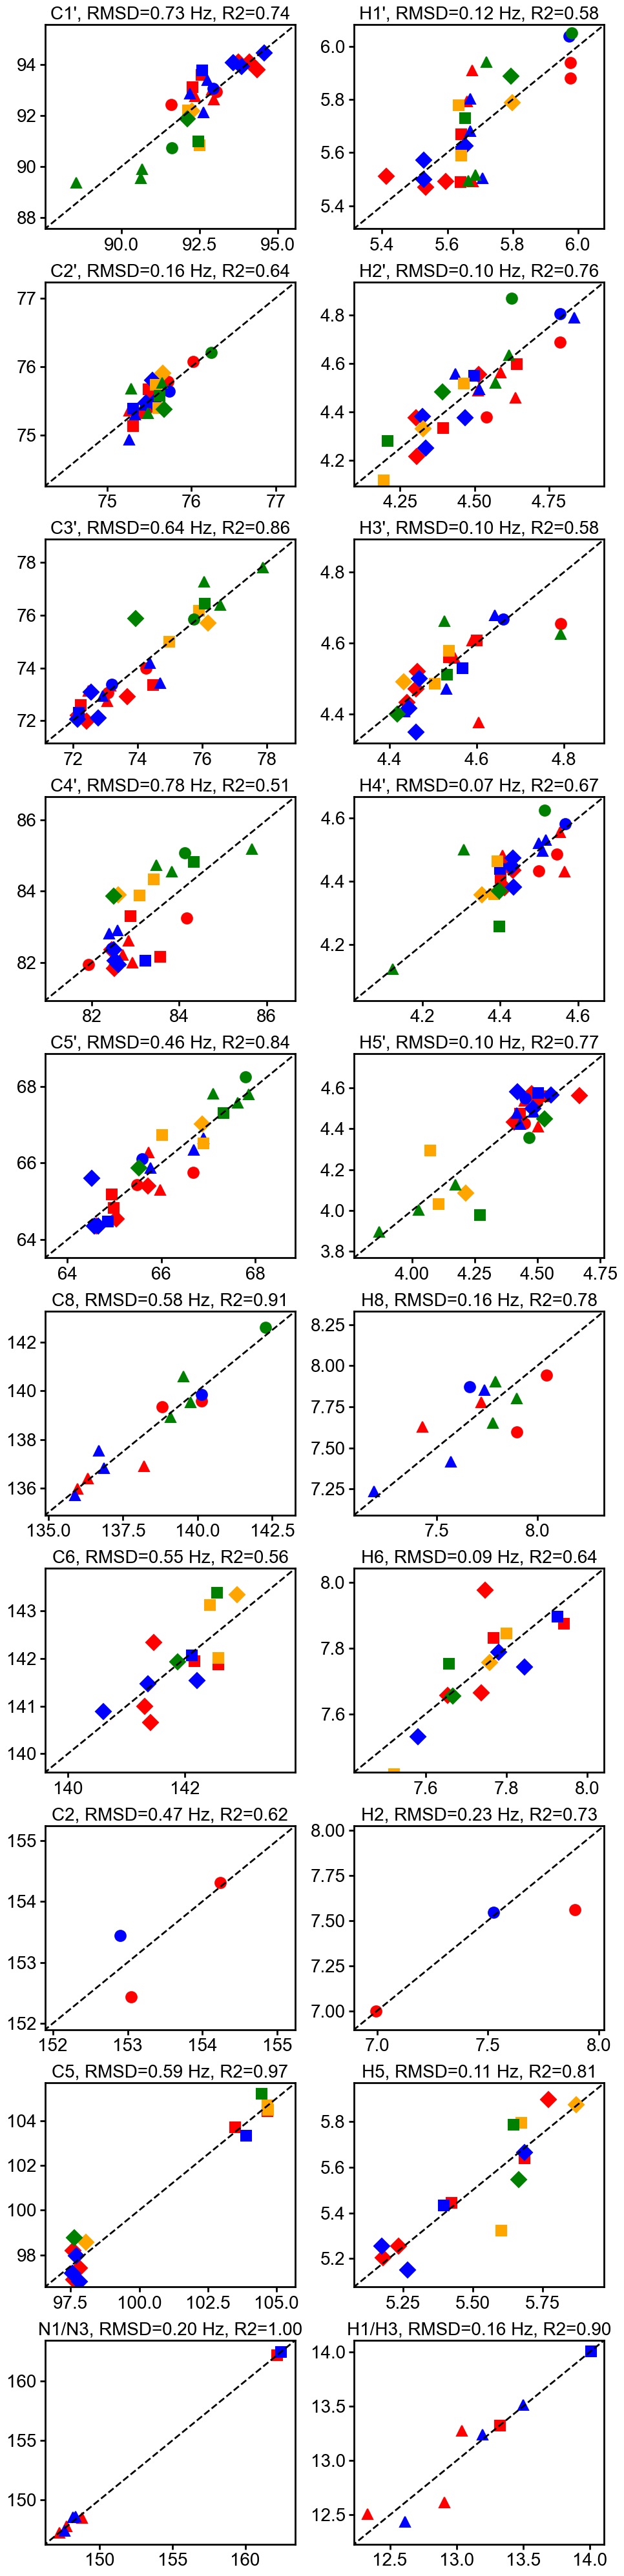

In [43]:
# FARFAR-Unbiased wt-TAR RDC Optimized Ensemble (N=20) [Lowest RMSD]
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_DFT.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

tar_seq = "GGCAGAUCUGAGCCUGGGAGCUCUCUGCC"
res_name = []
res_type = []
for idx, row in df.iterrows():
    resi = row['res']
    res_name_ = tar_seq[resi-17]
    if res_name_ == "A" or res_name_ == "G":
        res_type_ = "PUR"
    else:
        res_type_ = "PYR"
    res_name.append(res_name_)
    res_type.append(res_type_)

df["res_name"] = res_name
df["res_type"] = res_type

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    A_filter = (df["res_name"] == "A")
    U_filter = (df["res_name"] == "U")
    G_filter = (df["res_name"] == "G")
    C_filter = (df["res_name"] == "C")

    values = []
    mvalues = []
    values_H = []
    mvalues_H = []
    
    # ADENINE:
    if df.loc[filter1 & A_filter].shape[0] > 0:
        # Purines exist:
        x = df.loc[filter1 & A_filter]["shift_ens_avg"]
        y = df.loc[filter1 & A_filter]["shift_nmr_avg"]
        m_A, b_A = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & A_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & A_filter]["shift_nmr_avg"]
        m_H_A, b_H_A = np.polyfit(x_H, y_H, 1)
        print(resonance , "Adenine  13C/15N : y = %3.2f x + %3.2f"%(m_A, b_A))
        print(resonance , "Adenine  1H : y = %3.2f x + %3.2f"%(m_H_A, b_H_A))
        values += (x*m_A + b_A).tolist()
        values_H += (x_H*m_H_A + b_H_A).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
    
    # URACIL
    if df.loc[filter1 & U_filter].shape[0] > 0:
        # Purines exist:
        x = df.loc[filter1 & U_filter]["shift_ens_avg"]
        y = df.loc[filter1 & U_filter]["shift_nmr_avg"]
        m_U, b_U = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & U_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & U_filter]["shift_nmr_avg"]
        m_H_U, b_H_U = np.polyfit(x_H, y_H, 1)
        print(resonance , "Uracil  13C/15N : y = %3.2f x + %3.2f"%(m_U, b_U))
        print(resonance , "Uracil  1H : y = %3.2f x + %3.2f"%(m_H_U, b_H_U))
        values += (x*m_U + b_U).tolist()
        values_H += (x_H*m_H_U + b_H_U).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
    
    # GUANINE
    if df.loc[filter1 & G_filter].shape[0] > 0:
        # Purines exist:
        x = df.loc[filter1 & G_filter]["shift_ens_avg"]
        y = df.loc[filter1 & G_filter]["shift_nmr_avg"]
        m_G, b_G = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & G_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & G_filter]["shift_nmr_avg"]
        m_H_G, b_H_G = np.polyfit(x_H, y_H, 1)
        print(resonance , "Guanine  13C/15N : y = %3.2f x + %3.2f"%(m_G, b_G))
        print(resonance , "Guanine  1H : y = %3.2f x + %3.2f"%(m_H_G, b_H_G))
        values += (x*m_G + b_G).tolist()
        values_H += (x_H*m_H_G + b_H_G).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
        
    # CYTOSINE
    if df.loc[filter1 & C_filter].shape[0] > 0:
        # Purines exist:
        x = df.loc[filter1 & C_filter]["shift_ens_avg"]
        y = df.loc[filter1 & C_filter]["shift_nmr_avg"]
        m_C, b_C = np.polyfit(x, y, 1)   
        x_H = df.loc[filter2 & C_filter]["shift_ens_avg"]
        y_H = df.loc[filter2 & C_filter]["shift_nmr_avg"]
        m_H_C, b_H_C = np.polyfit(x_H, y_H, 1)
        print(resonance , "Cytosine  13C/15N : y = %3.2f x + %3.2f"%(m_C, b_C))
        print(resonance , "Cytosine  1H : y = %3.2f x + %3.2f"%(m_H_C, b_H_C))
        values += (x*m_C + b_C).tolist()
        values_H += (x_H*m_H_C + b_H_C).tolist()
        mvalues += (y).tolist()
        mvalues_H += (y_H).tolist()
        
    
    
    
    # Set up limits of axes
    lim_up = max(values) + 1
    lim_down = min(values) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(values_H) + 0.1
    lim_down = min(values_H) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # ADENINE  O:
        df_f = df.loc[(mask[domain]) & (filter1 & A_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_A * df_f.shift_ens_avg + b_A, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        df_f = df.loc[(mask[domain]) & (filter2 & A_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_A * df_f.shift_ens_avg + b_H_A, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
            
        # URACIL S:
        df_f = df.loc[(mask[domain]) & (filter1 & U_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_U * df_f.shift_ens_avg + b_U, df_f.shift_nmr_avg, 's', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        df_f = df.loc[(mask[domain]) & (filter2 & U_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_U * df_f.shift_ens_avg + b_H_U, df_f.shift_nmr_avg, 's', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        # GUANINE ^:
        df_f = df.loc[(mask[domain]) & (filter1 & G_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_G * df_f.shift_ens_avg + b_G, df_f.shift_nmr_avg, '^', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        df_f = df.loc[(mask[domain]) & (filter2 & G_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_G * df_f.shift_ens_avg + b_H_G, df_f.shift_nmr_avg, '^', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        # CYTOSINE D:
        df_f = df.loc[(mask[domain]) & (filter1 & C_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m_C * df_f.shift_ens_avg + b_C, df_f.shift_nmr_avg, 'D', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        df_f = df.loc[(mask[domain]) & (filter2 & C_filter)]
        if df_f.shape[0] == 0:
            pass
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H_C * df_f.shift_ens_avg + b_H_C, df_f.shift_nmr_avg, 'D', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        
        
        
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    #x=np.array(x)
    #y=np.array(y)
    #x_H = np.array(x_H)
    #y_H = np.array(y_H)
    #np.array(mvalues)
    R2 = calc_r2(np.array(values), np.array(mvalues))
    RMSD = calc_rmsd(np.array(values), np.array(mvalues))
    
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2 = calc_r2(np.array(values_H), np.array(mvalues_H))
    RMSD = calc_rmsd(np.array(values_H), np.array(mvalues_H))
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD, R2), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/wtTAR_GS_ES1G34syn_Unbiased_LowestRMSD_Ensemble_DFT.pdf")
plt.show()

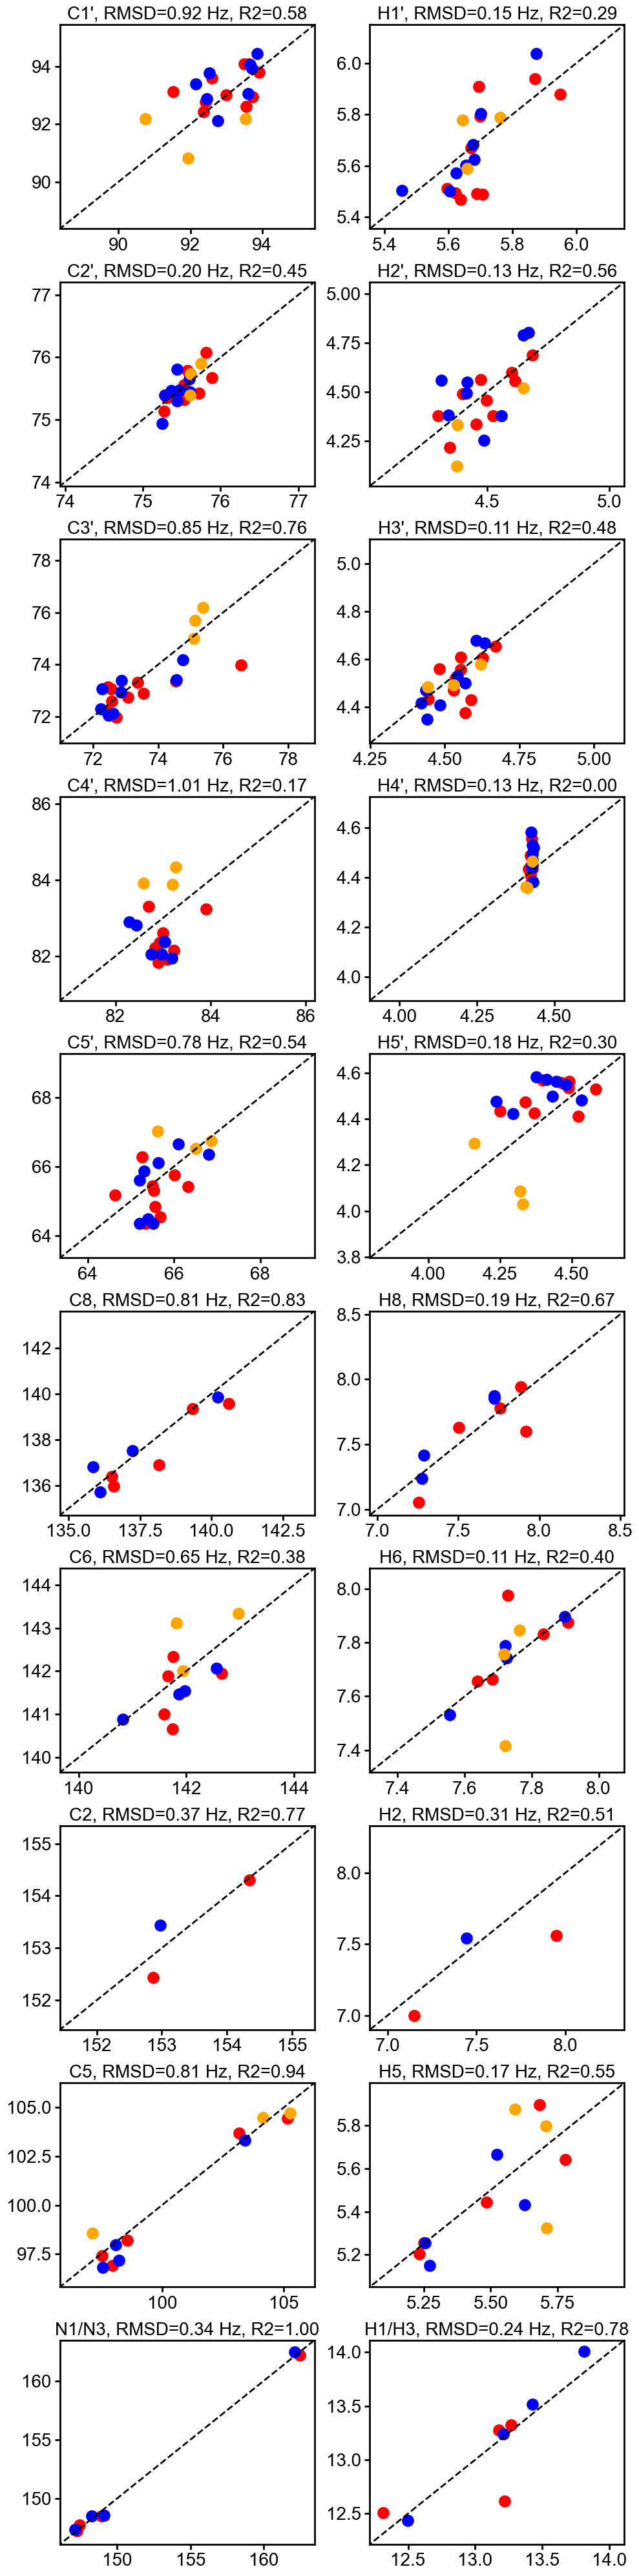

In [3]:
# FARFAR-NMR mt-TAR RDC Optimized Ensemble (N=20) from Shi et al, Nature Comm, 2020
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/FARFAR-wt-TAR-PoolRandom_predictedCS.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.nanmean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.nanstd(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/Orca_Benchmark_FARFAR_NMR_Ens_HS.pdf")
plt.show()

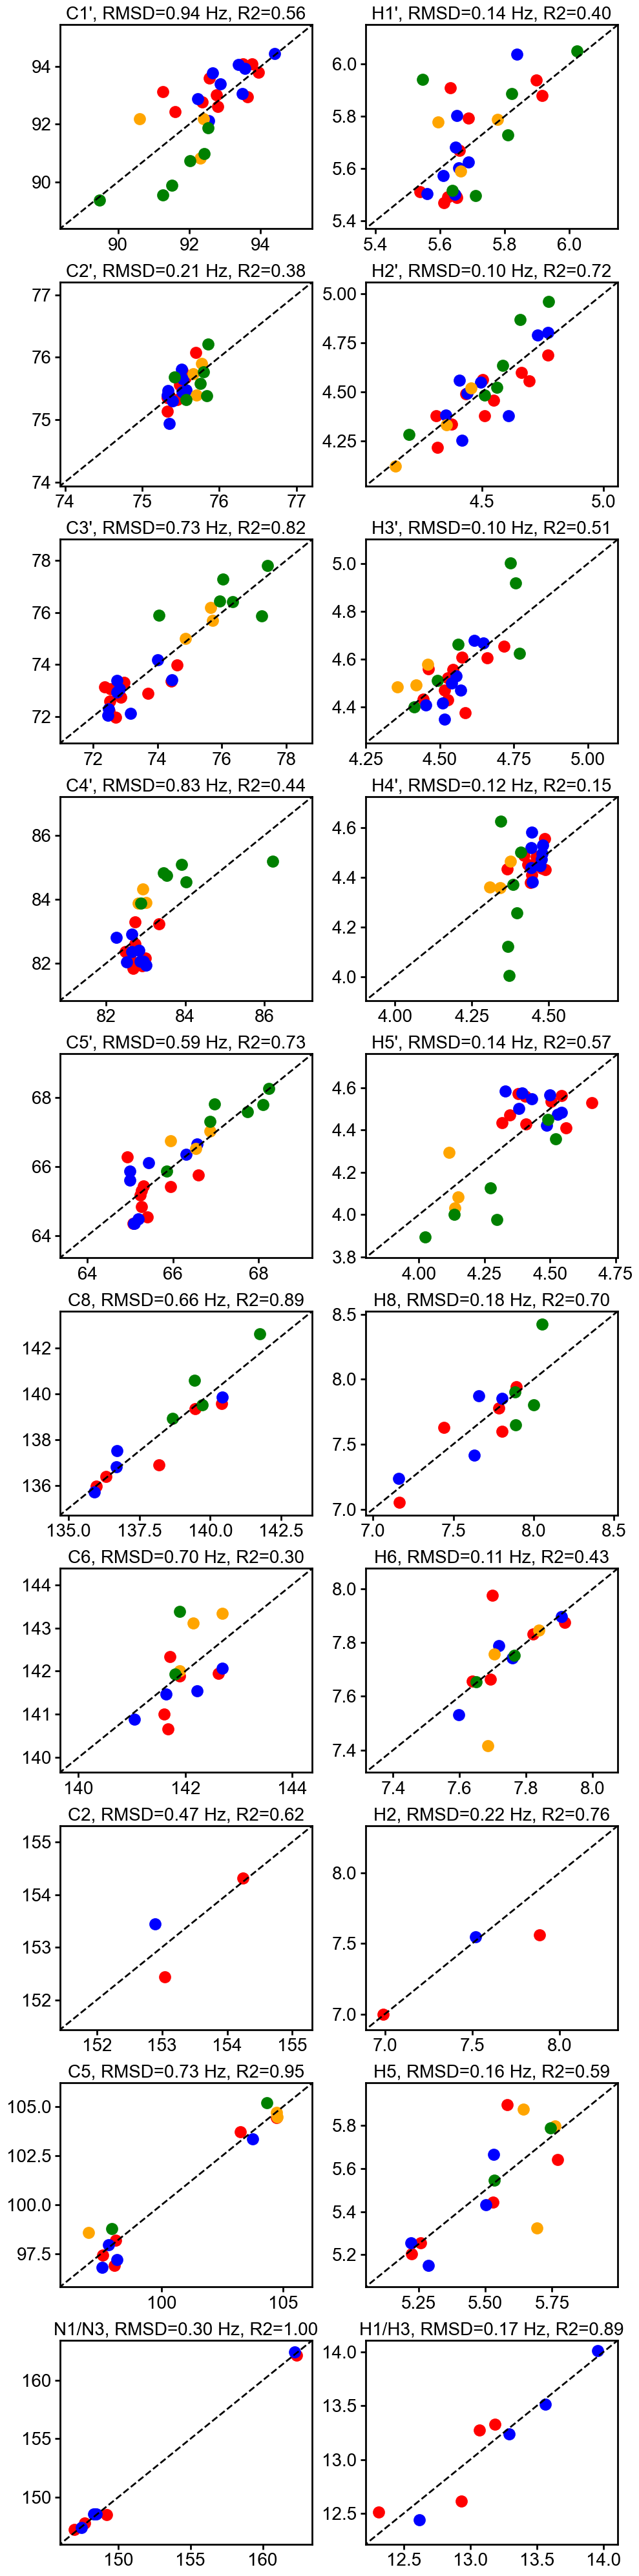

In [3]:
# FARFAR-Unbiased wt-TAR RDC Optimized Ensemble (N=20) [Lowest RMSD]
# Read all Orca predicted chemical shifts from ensemble and measured values
# Apply linear correction to predicted values (LS Reg)
# Plot linear correction applied prediction vs measurements by domain for 
# all 13C/15N/1H nuclei
# Save linear correction applied predictions in CSV file

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
dfp['shift_ens_avg'] = np.mean(dfp.iloc[:,2:], axis=1)
dfp['shift_ens_std'] = np.std(dfp.iloc[:,2:], axis=1)
dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std"]]
dfm = dfm.loc[:, ["Resi", "Atom", "Shift", "SDev"]].rename(columns = {
    'Resi': 'res', 'Atom': 'atom', 'Shift': 'shift_nmr_avg', 'SDev': 'shift_nmr_std'})
df = dfm.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L':'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))

# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["shift_nmr_avg"]
    m, b = np.polyfit(x, y, 1)   
    #print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
    x_H = df.loc[filter2]["shift_ens_avg"]
    y_H = df.loc[filter2]["shift_nmr_avg"]
    m_H, b_H = np.polyfit(x_H, y_H, 1)   
    #print(resonance_H , ": y = %3.2f x + %3.2f"%(m_H, b_H))
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1
    lim_down = min(np.min(y), np.min(x*m+b)) - 1
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    lim_up = max(np.max(y_H), np.max(x_H*m_H+b_H)) + 0.1
    lim_down = min(np.min(y_H), np.min(x_H*m_H+b_H)) - 0.1
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_ens_avg + b, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter2)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m_H * df_f.shift_ens_avg + b_H, df_f.shift_nmr_avg, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m_H*x_H+b_H, y_H)
    RMSD_H = calc_rmsd(m_H*x_H+b_H, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%(resonance_H, RMSD_H, R2_H), fontsize=20)
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
plt.savefig("plots/FINAL_w_avg_Outlier_Fixed.pdf")
plt.show()